# Predicting Animal Shelter Outcomes
[Reference](https://medium.com/vickdata/predicting-animal-shelter-outcomes-4c5fad5dbb4f)

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/')
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import re

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
train.shape

(26729, 10)

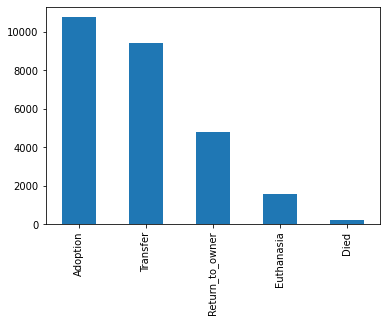

In [6]:
train['OutcomeType'].value_counts().plot.bar()

In [7]:
train.dtypes

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

In [8]:
columns = train.columns
for column in columns:
    print(column)
    print(train[column].nunique())

AnimalID
26729
Name
6374
DateTime
22918
OutcomeType
5
OutcomeSubtype
16
AnimalType
2
SexuponOutcome
5
AgeuponOutcome
44
Breed
1380
Color
366


# Processing categorical data

## - One hot encoding
## - Label encoding
## - Ordinal or continuous variables encoding

# Handling missing values

In [9]:
train.apply(lambda x: sum(x.isnull()/len(train)))

AnimalID          0.000000
Name              0.287740
DateTime          0.000000
OutcomeType       0.000000
OutcomeSubtype    0.509260
AnimalType        0.000000
SexuponOutcome    0.000037
AgeuponOutcome    0.000673
Breed             0.000000
Color             0.000000
dtype: float64

"Name" and "OutcomeSubtype" has a lot of missing values

In [10]:
train = train.drop('OutcomeSubtype', axis=1)

In [11]:
train['Name'] = train[['Name']].fillna(value=0)
train['has_name'] = (train['Name'] != 0).astype('int64')
train = train.drop('Name', axis=1)

In [12]:
train = train.apply(lambda x:x.fillna(x.value_counts().index[0]))
train.apply(lambda x: sum(x.isnull()/len(train)))

AnimalID          0.0
DateTime          0.0
OutcomeType       0.0
AnimalType        0.0
SexuponOutcome    0.0
AgeuponOutcome    0.0
Breed             0.0
Color             0.0
has_name          0.0
dtype: float64

In [13]:
train = train.drop('AnimalID', axis=1)

In [14]:
color_counts = train['Color'].value_counts()
color_others = set(color_counts[color_counts < 300].index)
train['top_colors'] = train['Color'].replace(list(color_others), 'Others')
print(train['top_colors'].nunique())

28


In [15]:
train['top_colors'].value_counts()

Others                 6008
Black/White            2824
Black                  2292
Brown Tabby            1635
Brown Tabby/White       940
White                   931
Brown/White             884
Orange Tabby            841
Tan/White               773
Tricolor                752
Blue/White              702
Black/Tan               672
White/Black             643
Brown                   639
Tan                     628
White/Brown             569
Tortie                  530
Calico                  517
Orange Tabby/White      455
Blue                    450
Brown Brindle/White     450
Black/Brown             436
Blue Tabby              433
White/Tan               389
Red                     337
Torbie                  335
Brown/Black             333
Red/White               331
Name: top_colors, dtype: int64

In [16]:
train['breed_type'] = train.Breed.str.extract('({})'.format('|'.join(['Mix'])),
                                              flags=re.IGNORECASE, expand=False).str.lower().fillna('pure')

In [17]:
train['multi_colors'] = train['Color'].apply(lambda x : 1 if '/' in x else 0)

In [18]:
train['AgeuponOutcome'].value_counts()

1 year       3987
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       531
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
7 months      288
9 years       288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
6 days         50
4 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: AgeuponOutcome, dtype: int64

In [19]:
def age_converter(row):
    age_string = row['AgeuponOutcome']
    [age,unit] = age_string.split(" ")
    unit = unit.lower()
    if("day" in unit):
        if age=='0': return 1
        return int(age)
    if("week" in unit):
        if(age)=='0': return 7
        return int(age)*7
    elif("month" in unit):
        if(age)=='0': return 30
        return int(age) * 4*7
    elif("year" in unit):
        if(age)=='0': return 365
        return int(age) * 4*12*7
train['age_numeric'] = train.apply(age_converter, axis=1)
train = train.drop('AgeuponOutcome', axis=1)

In [20]:
train = train.drop(['Breed','Color', 'DateTime'], axis=1)

In [21]:
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns

In [22]:
categorical_features = train.select_dtypes(include=['object']).drop(['OutcomeType'], axis=1).columns

In [23]:
dummy_columns = pd.get_dummies(train[categorical_features])

In [24]:
final_train = pd.concat([dummy_columns, train],axis=1)

In [25]:
final_train = final_train.drop(['AnimalType', 'breed_type', 'SexuponOutcome', 'top_colors'], axis=1)

# Building a model

In [26]:
X = final_train.drop('OutcomeType', axis=1)
y = final_train['OutcomeType']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [28]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                            random_state=0)

In [29]:
rf_model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.5948372615039281


In [30]:
y_prob = rf_model.predict_proba(X_test)
print(log_loss(y_test, y_prob))

1.0822259028580448


<function matplotlib.pyplot.show>

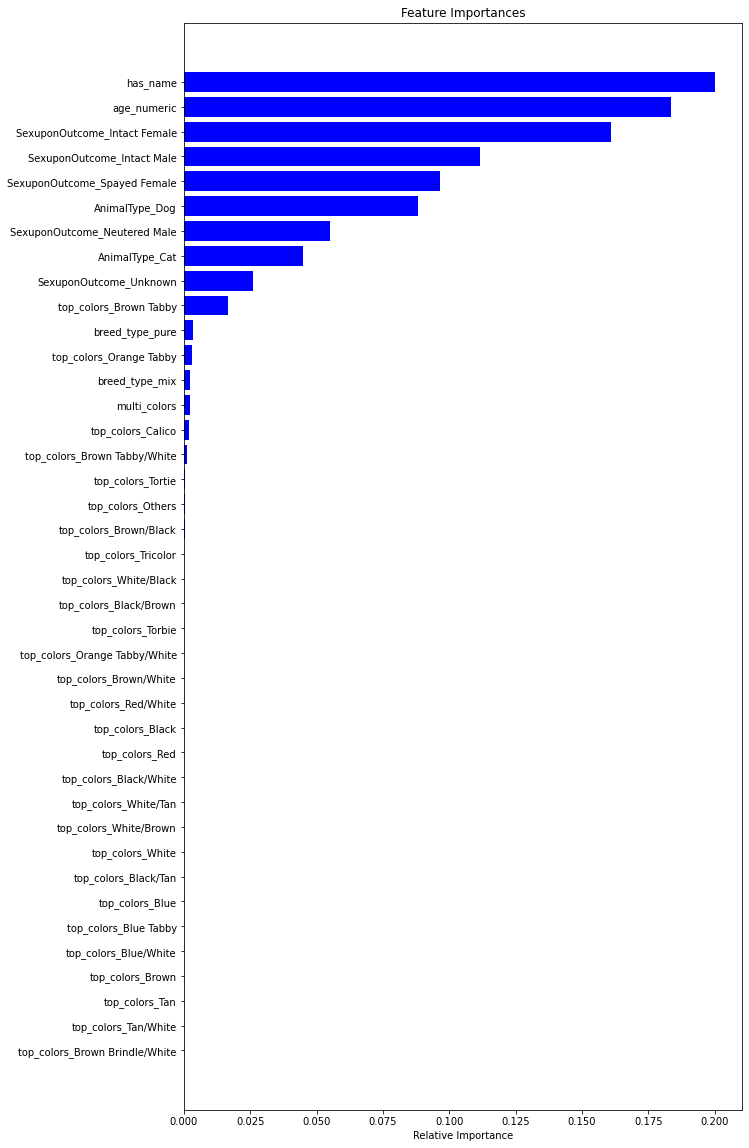

In [31]:
features=X.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show